<a href="https://colab.research.google.com/github/francoislegac/brain_tumor_classification_segmentation/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tumors segmentation


After Brain MRI classification let's try to detect brain tumors using segmentation on MRI scnas. Segmentation in this context is about classifying every pixel in the image between 2 classes: tumor or background. 

The dataset comes from The Cancer Imaging Archive (TCIA). It contains 3930 Brain MRI scans in .tif format along with their corresponding masks

source: 

Github: https://github.com/Aryavir07/Detecting-Brain-Tumor-Using-Deep-Learning/blob/main/Detecting%20Brain%20Tumor%20Using%20MRI%20Scan.ipynb

Kaggle tips on image segmentation: https://neptune.ai/blog/image-segmentation-tips-and-tricks-from-kaggle-competitions

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import DenseNet121 # 2017 architecture
from tensorflow.keras.models import Model, load_model
#from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
#from IPython.display import display
#from tensorflow.python.keras import *
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
#from tensorflow.keras.layers import *
#from tensorflow.keras import backend as K
#from keras import optimizers

from IPython.display import clear_output


In [2]:
from google.colab import drive 

drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
os.chdir('drive/MyDrive/Colab Notebooks/dl_projects_2021/segmentation/')

In [4]:
! ! ls

archive.zip  kaggle_3m	model.png	    utilities.py
df.csv	     logs	segmentation.ipynb


In [ ]:
#! unzip archive.zip

## Dataset description

This dataset contains brain MR images together with segmentation masks. They correspond to 110 patients

- images in `.tif` and corresponding masks which have a `_mask` suffix.
- Tumor genomic clusters and patient data is provided in `data.csv` file.

The dataset is organized into 110 folders named after case ID. Each folder contains MR images with the following naming convention:
`TCGA_<institution-code>_<patient-id>_<slice-number>.tif`

In [5]:
patient_data = pd.read_csv('kaggle_3m/data.csv')

In [6]:
patient_data.head()

,Patient,RNASeqCluster,MethylationCluster,miRNACluster,CNCluster,RPPACluster,OncosignCluster,COCCluster,histological_type,neoplasm_histologic_grade,tumor_tissue_site,laterality,tumor_location,gender,age_at_initial_pathologic,race,ethnicity,death01
0,TCGA_CS_4941,2.0,4.0,2,2.0,NaN,3.0,2,1.0,2.0,1.0,3.0,2.0,2.0,67.0,3.0,2.0,1.0
1,TCGA_CS_4942,1.0,5.0,2,1.0,1.0,2.0,1,1.0,2.0,1.0,3.0,2.0,1.0,44.0,2.0,NaN,1.0
2,TCGA_CS_4943,1.0,5.0,2,1.0,2.0,2.0,1,1.0,2.0,1.0,1.0,2.0,2.0,37.0,3.0,NaN,0.0
3,TCGA_CS_4944,NaN,5.0,2,1.0,2.0,1.0,1,1.0,1.0,1.0,3.0,6.0,2.0,50.0,3.0,NaN,0.0
4,TCGA_CS_5393,4.0,5.0,2,1.0,2.0,3.0,1,1.0,2.0,1.0,1.0,6.0,2.0,39.0,3.0,NaN,0.0


## Data Wrangling

Let's seperate images that have a tumor vs images that don't.

In [ ]:
#TCGA_HT_A616_19991226
#TCGA_HT_A616_19991226_28.tif
#TCGA_HT_A616_19991226_28_mask.tif

def check_is_tumor(mask_path):
  mask = cv2.imread(mask_path)
  if np.sum(mask) == 0:
    return 0
  else:
    return 1

def find_corresponding_mask(img_name, masks):
  name = img_name.split('.')[0]
  mask_name = [x for x in masks if x.startswith(name)][0]
  return ROOT + '/' + DIR + '/' + mask_name 

In [ ]:
ROOT = 'kaggle_3m'
l = []
count = 0
for DIR in os.listdir(ROOT):
  #check if it's a folder
  if not os.path.isdir(ROOT + '/' + DIR):
    continue
  else:
    list_of_files = os.listdir(ROOT + '/' + DIR)
    imgs = [x for x in list_of_files if 'mask' not in x]
    masks = [x for x in list_of_files if 'mask' in x]
    assert len(imgs) == len(masks), 'some images don\'t have their corresponding \
    mask'
    for FILE in imgs:
      patient_id = DIR
      img_path = ROOT + '/' + DIR + '/' + FILE
      mask_path = find_corresponding_mask(FILE, masks)
      has_a_tumor = check_is_tumor(mask_path)
      
      if count%500==0: print(count)
      row = [patient_id, img_path, mask_path, has_a_tumor]
      l.append(row)
      count +=1

df = pd.DataFrame(l, columns = ['patient_id', 
                                'img_path', 
                                'mask_path', 
                                'has_a_tumor'])

0
500
1000
1500
2000
2500
3000
3500


In [7]:
#df.to_csv(df.csv)
df = pd.read_csv('df.csv', index_col=0)

In [8]:
df.head(n =3)

,patient_id,img_path,mask_path,has_a_tumor
0,TCGA_CS_4941_19960909,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,0
1,TCGA_CS_4941_19960909,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,1
2,TCGA_CS_4941_19960909,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_1...,1


In [9]:
#we keep only the images with tumor
idx = df[df.has_a_tumor == 1].index
X = df.iloc[idx]

In [10]:
X_train, X_val = train_test_split(X, test_size=0.30)
X_test, X_val = train_test_split(X_val, test_size=0.15)

In [11]:
X_train.head()

,patient_id,img_path,mask_path,has_a_tumor
2748,TCGA_FG_A4MT_20020212,kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,kaggle_3m/TCGA_FG_A4MT_20020212/TCGA_FG_A4MT_2...,1
1631,TCGA_DU_7304_19930325,kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_1...,kaggle_3m/TCGA_DU_7304_19930325/TCGA_DU_7304_1...,1
3508,TCGA_HT_7884_19980913,kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_1...,kaggle_3m/TCGA_HT_7884_19980913/TCGA_HT_7884_1...,1
1277,TCGA_DU_7014_19860618,kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,kaggle_3m/TCGA_DU_7014_19860618/TCGA_DU_7014_1...,1
1510,TCGA_DU_7300_19910814,kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_1...,kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_1...,1


In [12]:
def custom_datagen(df, img_size = (256,256), batch_size=16):
  '''
  load, resize and normalize 
  '''
  c = 0
  df.sample(frac=1) #shuffle the df
  img_paths = list(df['img_path'])
  mask_paths = list(df['mask_path'])

  while (True):
    img = np.zeros((batch_size, img_size[0], img_size[1] ,3)).astype('float')
    mask = np.zeros((batch_size, img_size[0], img_size[1], 1)).astype('float')

    for i in range(c, c + batch_size):
      #img
      train_img = cv2.imread(img_paths[i])/255
      train_img = cv2.resize(train_img, (img_size[0], img_size[1]))
      img[i-c] = train_img #add to array - img[0], img[1], and so on.

      #mask
      train_mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)/255
      train_mask = cv2.resize(train_mask, (img_size[0], img_size[1]))
      train_mask = train_mask.reshape(img_size[0], img_size[1], 1) # Add extra dimension for parity with train_img size [512 * 512 * 3]
      mask[i-c] = train_mask

    c+= batch_size
    if(c+batch_size >= len(df)):
      c = 0
      df.sample(frac=1)
      print('randomizing again')
    yield img, mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(16, 256, 256, 3) (16, 256, 256, 1)


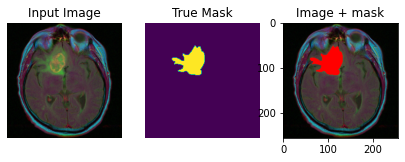

In [13]:
#let's see one batch example
batch = next(custom_datagen(X))
imgs, masks = batch

print(imgs.shape, masks.shape)

def display(img, mask):
  '''
  input: img and mask are numpy arrays
  output: plot of img, mask and img + mask
  '''
  fig, ax = plt.subplots(1,3,figsize=(7,7))
  ax[0].imshow(img)
  ax[0].set_axis_off()
  ax[0].set_title('Input Image')
  ax[1].imshow(np.squeeze(mask))
  ax[1].set_axis_off()
  ax[1].set_title('True Mask')
  img[np.squeeze(mask) == 1] = (255,0,0)
  ax[2].imshow(img)
  ax[2].set_title('Image + mask')
  ;

display(imgs[0], masks[0])

In [14]:
train_generator = custom_datagen(
    X_train, batch_size=16
)
val_generator = custom_datagen(
    X_val, batch_size=16
)

In [15]:
#callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger, TensorBoard
#mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_acc',save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=20, verbose=1)
tb = TensorBoard(log_dir="logs/", histogram_freq=0, write_graph=True, write_images=False)
cv = CSVLogger("logs/log.csv" , append=True , separator=',')
rl = ReduceLROnPlateau(monitor='loss',factor=0.1,patience=5,verbose=1,mode="max",min_lr=0.0001)


### Unet baseline - CE loss

In [16]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, BatchNormalization, Activation, Dropout

In [23]:
def conv_block(tensor, nfilters, size=3, padding='same', initializer="he_normal"):
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(filters=nfilters, kernel_size=(size, size), padding=padding, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


def deconv_block(tensor, residual, nfilters, size=3, padding='same', strides=(2, 2)):
    y = Conv2DTranspose(nfilters, kernel_size=(size, size), strides=strides, padding=padding)(tensor)
    y = concatenate([y, residual], axis=3)
    y = conv_block(y, nfilters)
    return y


def Unet(h, w, filters):
# down
    input_layer = Input(shape=(h, w, 3), name='image_input')
    conv1 = conv_block(input_layer, nfilters=filters)
    conv1_out = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = conv_block(conv1_out, nfilters=filters*2)
    conv2_out = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = conv_block(conv2_out, nfilters=filters*4)
    conv3_out = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = conv_block(conv3_out, nfilters=filters*8)
    conv4_out = MaxPooling2D(pool_size=(2, 2))(conv4)
    conv4_out = Dropout(0.5)(conv4_out)
    conv5 = conv_block(conv4_out, nfilters=filters*16)
    conv5 = Dropout(0.5)(conv5)
# up
    deconv6 = deconv_block(conv5, residual=conv4, nfilters=filters*8)
    deconv6 = Dropout(0.5)(deconv6)
    deconv7 = deconv_block(deconv6, residual=conv3, nfilters=filters*4)
    deconv7 = Dropout(0.5)(deconv7) 
    deconv8 = deconv_block(deconv7, residual=conv2, nfilters=filters*2)
    deconv9 = deconv_block(deconv8, residual=conv1, nfilters=filters)
    output_layer = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(deconv9)

    model = Model(inputs=input_layer, outputs=output_layer, name='Unet')
    return model

In [ ]:
img_size= (256,256)
model = Unet(img_size[0] , img_size[0] , 64)
#model.summary()
#tf.keras.utils.plot_model(model, show_shapes=True)
model.compile(
    optimizer = 'adam',
    loss= tf.keras.losses.binary_crossentropy,
    metrics= [tf.keras.metrics.binary_accuracy]
)

In [ ]:
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=1,
    steps_per_epoch=1,
    validation_steps=1,
    callbacks=[es, tb, cv, rl]
)

1/1 [==============================] - 172s 172s/step - loss: 0.7878 - binary_accuracy: 0.5797 - val_loss: 0.7236 - val_binary_accuracy: 0.4381


In [17]:
#Let's show a prediction
def create_mask(pred_mask, threshold=0.5):
  tmp = np.zeros(pred_mask.shape)
  tmp[pred_mask > threshold] = 1 
  return np.squeeze(tmp)

def show_predictions(img, mask, prediction):
  fig, ax = plt.subplots(1,3,figsize=(7,7))
  ax[0].imshow(img)
  ax[0].set_axis_off()
  ax[0].set_title('Input Image')
  ax[1].imshow(np.squeeze(mask), cmap='gray')
  ax[1].set_axis_off()
  ax[1].set_title('True Mask')
  ax[2].imshow(prediction, cmap='gray')
  ax[2].set_title('Predicted Mask')
  ax[2].set_axis_off()
  ;

In [34]:
#Let's retrieve a test image from our generator
batch = next(custom_datagen(X_test))
imgs, masks = batch
sample_img, sample_mask = imgs[0], masks[0]

In [ ]:
prediction = model.predict(sample_img[tf.newaxis, ...]) #model.predict need a (1, 256, 256, 3) input not (256, 256, 3)

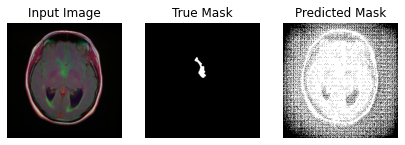

In [ ]:
show_predictions(sample_img, sample_mask, create_mask(prediction))

In [18]:
#Observons comment le modèle s'améliore pendant qu'il s'entraîne.
# Pour accomplir cette tâche, une fonction de rappel est définie ci-dessous.
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(
        sample_img,
        sample_mask,
        create_mask(model.predict(sample_img[tf.newaxis, ...]))
    )
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

Epoch 1/5
1/1 [==============================] - 149s 149s/step - loss: 0.6558 - binary_accuracy: 0.6184 - val_loss: 0.9196 - val_binary_accuracy: 0.1557

Sample Prediction after epoch 1

Epoch 2/5
1/1 [==============================] - 141s 141s/step - loss: 0.5634 - binary_accuracy: 0.8102 - val_loss: 5.3043 - val_binary_accuracy: 0.0575

Sample Prediction after epoch 2

Epoch 3/5
1/1 [==============================] - 136s 136s/step - loss: 0.4184 - binary_accuracy: 0.9050 - val_loss: 39.4598 - val_binary_accuracy: 0.0348

Sample Prediction after epoch 3

Epoch 4/5
1/1 [==============================] - 149s 149s/step - loss: 0.3457 - binary_accuracy: 0.9596 - val_loss: 61.4053 - val_binary_accuracy: 0.0242

Sample Prediction after epoch 4

Epoch 5/5
1/1 [==============================] - 138s 138s/step - loss: 0.3069 - binary_accuracy: 0.9682 - val_loss: 1141.8040 - val_binary_accuracy: 0.0297

Sample Prediction after epoch 5



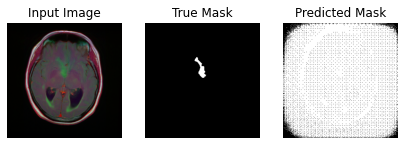

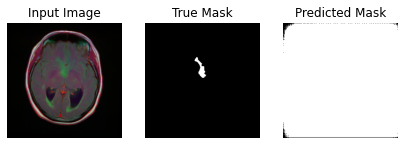

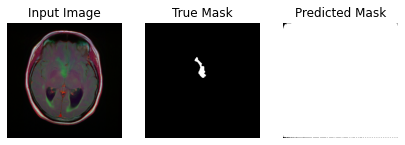

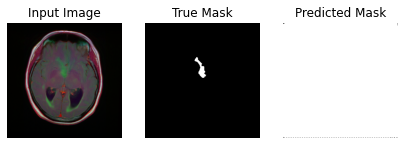

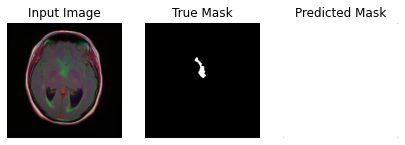

In [ ]:
EPOCH = 5
#tf.keras.metrics.MeanIoU(num_classes=2)
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=EPOCH,
    steps_per_epoch=1,
    validation_steps=1,
    callbacks=[DisplayCallback(), es, tb, cv, rl]
)

#Baseline Unet with Jaccard Loss

source: https://www.youtube.com/watch?v=BNPW1mYbgS4

In [19]:
from keras import backend as K

In [20]:
def jaccard_coef(y_true, y_pred): #also called Jaccard Index or IoU
  y_true_f = K.flatten(y_true)
  y_pred_f =K.flatten(y_pred)
  intersection = K.sum(y_true_f*y_pred_f)
  return (intersection + 1.0)/(K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

#note that we add a '-' for the loss as we want it to decrease 
#when we do better predictions. 
def jaccard_coef_loss(y_true, y_pred):
  return - jaccard_coef(y_true, y_pred)


In [24]:
img_size= (256,256)
model = Unet(img_size[0] , img_size[0] , 64)

model.compile(
    optimizer = 'adam',
    loss= [jaccard_coef_loss],
    metrics= [jaccard_coef]
)

In [ ]:
history = model.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=1,
    steps_per_epoch=1,
    validation_steps=1,
    callbacks=[DisplayCallback(), es, tb, cv, rl]
)

1/1 [==============================] - 153s 153s/step - loss: -0.0673 - jaccard_coef: 0.0673 - val_loss: -0.0228 - val_jaccard_coef: 0.0228


#Using ResUnet

In [25]:
def resblock(X, f):
  # make a copy of input
  X_copy = X
  # main path
  # Read more about he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X) 
  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  # Short path
  # Read more here: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33
  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)
  # Adding the output from main path and short path together
  X = Add()([X,X_copy])
  X = Activation('relu')(X)
  return X


# function to upscale and concatenate the values passsed
def upsample_concat(x, skip):
    x = UpSampling2D((2,2))(x)
    merge = Concatenate()([x, skip])
    return merge

def create_model():
  input_shape = (256,256,3)
  # Input tensor shape
  X_input = Input(input_shape)
  # Stage 1
  conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
  conv1_in = BatchNormalization()(conv1_in)
  conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
  conv1_in = BatchNormalization()(conv1_in)
  pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)
  # Stage 2
  conv2_in = resblock(pool_1, 32)
  pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)
  # Stage 3
  conv3_in = resblock(pool_2, 64)
  pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)
  # Stage 4
  conv4_in = resblock(pool_3, 128)
  pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)
  # Stage 5 (Bottle Neck)
  conv5_in = resblock(pool_4, 256)
  # Upscale stage 1
  up_1 = upsample_concat(conv5_in, conv4_in)
  up_1 = resblock(up_1, 128)
  # Upscale stage 2
  up_2 = upsample_concat(up_1, conv3_in)
  up_2 = resblock(up_2, 64)
  # Upscale stage 3
  up_3 = upsample_concat(up_2, conv2_in)
  up_3 = resblock(up_3, 32)
  # Upscale stage 4
  up_4 = upsample_concat(up_3, conv1_in)
  up_4 = resblock(up_4, 16)
  # Final Output
  output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)
  return Model(inputs = X_input, outputs = output )



In [26]:
#loss
#focal_tversky, tversky_loss, tversky
epsilon = 1e-5
smooth = 1

def tversky(y_true, y_pred):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [27]:
from tensorflow.keras.layers import MaxPool2D, Add, UpSampling2D, Concatenate

In [28]:
res_unet = create_model()

In [29]:
#definition of some hyperparameters
adam = tf.keras.optimizers.Adam(learning_rate = 0.05, epsilon = 0.1)

res_unet.compile(
    optimizer= adam,
    loss= [focal_tversky],
    metrics=[tversky],
)

In [30]:
X_train.shape, X_val.shape

((1051, 4), (68, 4))

Epoch 1/20
65/65 [==============================] - 1117s 17s/step - loss: 0.8586 - tversky: 0.1836 - val_loss: 0.9186 - val_tversky: 0.1069
Epoch 2/20
65/65 [==============================] - 509s 8s/step - loss: 0.7279 - tversky: 0.3420 - val_loss: 0.8991 - val_tversky: 0.1320
Epoch 3/20
65/65 [==============================] - 508s 8s/step - loss: 0.4981 - tversky: 0.6025 - val_loss: 0.9158 - val_tversky: 0.1105
Epoch 4/20
65/65 [==============================] - ETA: 0s - loss: 0.4467 - tversky: 0.6566randomizing again
randomizing again
65/65 [==============================] - 507s 8s/step - loss: 0.4467 - tversky: 0.6566 - val_loss: 0.7304 - val_tversky: 0.3410
Epoch 5/20
65/65 [==============================] - 507s 8s/step - loss: 0.4071 - tversky: 0.6964 - val_loss: 0.4641 - val_tversky: 0.6345
Epoch 6/20
65/65 [==============================] - 508s 8s/step - loss: 0.3826 - tversky: 0.7204 - val_loss: 0.4750 - val_tversky: 0.6228
Epoch 7/20
65/65 [=============================

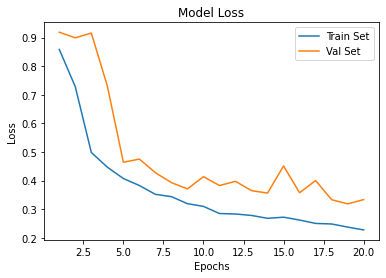

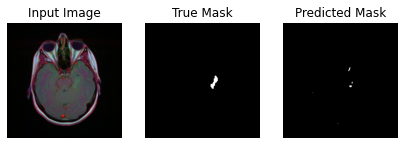

In [36]:
BATCH_SIZE = 16

history = res_unet.fit(
    train_generator, 
    validation_data=val_generator, 
    epochs=20,
    steps_per_epoch = X_train.shape[0] //BATCH_SIZE,
    validation_steps = X_val.shape[0] // BATCH_SIZE,
    #callbacks=[es, tb, cv, rl]
)

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

fig, ax = plt.subplots()
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.savefig('history.png')

prediction = res_unet.predict(sample_img[tf.newaxis, ...])
show_predictions(sample_img, sample_mask, create_mask(prediction))
plt.savefig('pred.png')

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

fig, ax = plt.subplots()
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.savefig('history.png')

prediction = res_unet.predict(sample_img[tf.newaxis, ...])
show_predictions(sample_img, sample_mask, create_mask(prediction))
plt.savefig('pred.png')

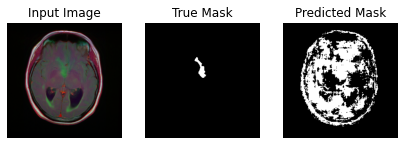

In [ ]:
prediction = res_unet.predict(sample_img[tf.newaxis, ...])
show_predictions(sample_img, sample_mask, create_mask(prediction))


In [ ]:
def save_model(model):
  '''
  input: tf model
  '''
  with open('resunet.json', 'w') as f:
    f.write(model.to_json())

def load_model(model_name):
  '''
  input: name of the model (str)
  ouput: tf model
  '''
  with open(model_name) as f:
    model = f.read()
  return tf.keras.models.model_from_json(model)
